### Pyspark initialization 

In [1]:
#import spark
from pyspark.sql import SparkSession
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ass2 BNPL group 28")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/03 06:49:29 WARN Utils: Your hostname, Rudyletsgo resolves to a loopback address: 127.0.1.1; using 172.30.250.116 instead (on interface eth0)
22/10/03 06:49:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/03 06:49:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Read data 

In [2]:
merchants = spark.read.parquet('../data/tables/tbl_merchants.parquet')
consumers = spark.read.parquet('../data/tables/consumer_user_details.parquet')
transactions1 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions2 = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
consumers_csv = spark.read.options(header='True', inferSchema='True', delimiter='|').csv('../data/tables/tbl_consumer.csv')

In [3]:
consumers_csv = consumers_csv.withColumnRenamed("name", "user_name")
merchants = merchants.withColumnRenamed("name", "merchant_name")
transactions = transactions1.unionByName(transactions2)
transactions = transactions.unionByName(transactions3)

In [4]:
curated_csv = transactions.join(consumers, transactions.user_id == consumers.user_id, "leftouter").drop(consumers.user_id)
curated_csv = curated_csv.join(merchants, curated_csv.merchant_abn == merchants.merchant_abn, "leftouter").drop(merchants.merchant_abn)
curated_csv = curated_csv.join(consumers_csv, curated_csv.consumer_id == consumers_csv.consumer_id, "leftouter").drop(consumers_csv.consumer_id)

### General understanding of dataset

In [5]:
curated_csv.limit(5)
print(curated_csv.count(),len(curated_csv.columns))

14195505 13


In [6]:
curated_csv.columns

['user_id',
 'merchant_abn',
 'dollar_value',
 'order_id',
 'order_datetime',
 'consumer_id',
 'merchant_name',
 'tags',
 'user_name',
 'address',
 'state',
 'postcode',
 'gender']

In [7]:
from pyspark.sql.functions import col,isnan, when, count
curated_csv.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in curated_csv.columns]
   ).show()

AnalysisException: cannot resolve 'isnan(`order_datetime`)' due to data type mismatch: argument 1 requires (double or float) type, however, '`order_datetime`' is of date type.;
'Aggregate [count(CASE WHEN (isnan(cast(user_id#10L as double)) OR isnull(user_id#10L)) THEN user_id END) AS user_id#196L, count(CASE WHEN (isnan(cast(merchant_abn#11L as double)) OR isnull(merchant_abn#11L)) THEN merchant_abn END) AS merchant_abn#198L, count(CASE WHEN (isnan(dollar_value#12) OR isnull(dollar_value#12)) THEN dollar_value END) AS dollar_value#200L, count(CASE WHEN (isnan(cast(order_id#13 as double)) OR isnull(order_id#13)) THEN order_id END) AS order_id#202L, count(CASE WHEN (isnan(order_datetime#14) OR isnull(order_datetime#14)) THEN order_datetime END) AS order_datetime#204, count(CASE WHEN (isnan(cast(consumer_id#7L as double)) OR isnull(consumer_id#7L)) THEN consumer_id END) AS consumer_id#206L, count(CASE WHEN (isnan(cast(merchant_name#75 as double)) OR isnull(merchant_name#75)) THEN merchant_name END) AS merchant_name#208L, count(CASE WHEN (isnan(cast(tags#1 as double)) OR isnull(tags#1)) THEN tags END) AS tags#210L, count(CASE WHEN (isnan(cast(user_name#68 as double)) OR isnull(user_name#68)) THEN user_name END) AS user_name#212L, count(CASE WHEN (isnan(cast(address#57 as double)) OR isnull(address#57)) THEN address END) AS address#214L, count(CASE WHEN (isnan(cast(state#58 as double)) OR isnull(state#58)) THEN state END) AS state#216L, count(CASE WHEN (isnan(cast(postcode#59 as double)) OR isnull(postcode#59)) THEN postcode END) AS postcode#218L, count(CASE WHEN (isnan(cast(gender#60 as double)) OR isnull(gender#60)) THEN gender END) AS gender#220L]
+- Project [user_id#10L, merchant_abn#11L, dollar_value#12, order_id#13, order_datetime#14, consumer_id#7L, merchant_name#75, tags#1, user_name#68, address#57, state#58, postcode#59, gender#60]
   +- Join LeftOuter, (consumer_id#7L = cast(consumer_id#61 as bigint))
      :- Project [user_id#10L, merchant_abn#11L, dollar_value#12, order_id#13, order_datetime#14, consumer_id#7L, merchant_name#75, tags#1]
      :  +- Join LeftOuter, (merchant_abn#11L = merchant_abn#2L)
      :     :- Project [user_id#10L, merchant_abn#11L, dollar_value#12, order_id#13, order_datetime#14, consumer_id#7L]
      :     :  +- Join LeftOuter, (user_id#10L = user_id#6L)
      :     :     :- Union false, false
      :     :     :  :- Relation[user_id#10L,merchant_abn#11L,dollar_value#12,order_id#13,order_datetime#14] parquet
      :     :     :  :- Project [user_id#20L, merchant_abn#21L, dollar_value#22, order_id#23, order_datetime#24]
      :     :     :  :  +- Relation[user_id#20L,merchant_abn#21L,dollar_value#22,order_id#23,order_datetime#24] parquet
      :     :     :  +- Project [user_id#30L, merchant_abn#31L, dollar_value#32, order_id#33, order_datetime#34]
      :     :     :     +- Relation[user_id#30L,merchant_abn#31L,dollar_value#32,order_id#33,order_datetime#34] parquet
      :     :     +- Relation[user_id#6L,consumer_id#7L] parquet
      :     +- Project [name#0 AS merchant_name#75, tags#1, merchant_abn#2L]
      :        +- Relation[name#0,tags#1,merchant_abn#2L] parquet
      +- Project [name#56 AS user_name#68, address#57, state#58, postcode#59, gender#60, consumer_id#61]
         +- Relation[name#56,address#57,state#58,postcode#59,gender#60,consumer_id#61] csv


### Remove unused columns

In [ ]:
cols = ['address','gender']
#curated_csv2 = curated_csv.drop(curated_csv.address)
curated_csv3 = curated_csv.drop(*cols)
#curated_csv4 = curated_csv3.drop(curated_csv.user_name)
curated_csv3.limit(5)
print(curated_csv3.count(),len(curated_csv3.columns))

14195505 11


### Outlier analysis

In [ ]:
# check null value
curated_csv3 = curated_csv3.dropna()
print(curated_csv3.count(),len(curated_csv3.columns))

22/10/03 06:44:34 ERROR Executor: Exception in task 10.0 in stage 24.0 (TID 845)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:61)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:348)
	at org.apache.spark.io.ReadAheadInputStream.<init>(ReadAheadInputStream.java:105)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:74)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:523)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:4

[87.978s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 24.0 (TID 836): Retried waiting for GCLocker too often allocating 131074 words
[88.010s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 24.0 (TID 845): Retried waiting for GCLocker too often allocating 131074 words


22/10/03 06:44:34 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[Executor task launch worker for task 10.0 in stage 24.0 (TID 845),5,main]
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:61)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:348)
	at org.apache.spark.io.ReadAheadInputStream.<init>(ReadAheadInputStream.java:105)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:74)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:523)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at o

Py4JError: An error occurred while calling None.None

Check there are no duplicate order

In [ ]:
curated_csv4 = curated_csv3.distinct()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40463)
Traceback (most recent call last):
  File "/home/jiaruiq/miniconda3/envs/ads/lib/python3.8/site-packages/py4j/java_gateway.py", line 982, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jiaruiq/miniconda3/envs/ads/lib/python3.8/site-packages/py4j/java_gateway.py", line 1120, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:40463)

In [ ]:
curated_csv3.limit(5)

user_id,merchant_abn,dollar_value,order_id,order_datetime,merchant_name,postcode,field,revenue_level,take_rate,total_population,avg_personal_income_weekly,is_fraud
1730,60956456424,142.52,4ab37080-8690-428...,2021-08-20,Ultricies Digniss...,1135,"gift, card, novel...",b,4.69,9656,798.0,False
17274,24852446429,22.63,19000be3-b4a2-4cc...,2021-09-14,Erat Vitae LLP,1135,florists supplies...,c,2.94,9656,798.0,False
1730,43127814599,902.82,28698120-ee5a-42d...,2021-08-20,Nam Ligula Elit F...,1135,lawn and garden s...,b,3.58,9656,798.0,False
17454,21439773999,68.94,c9afee3b-1675-45e...,2021-09-14,Mauris Non Institute,1135,"cable, satellite,...",a,6.1,9656,798.0,False
6737,51279178333,19.73,c8fb7b8a-1224-47e...,2021-08-20,Neque LLC,1135,music shops - mus...,c,1.83,9656,798.0,False


In [ ]:
# check wrong data
from os import curdir
from pyspark.sql import functions as F
new_data = curated_csv3.filter(
    (F.col('user_id') > 0 )
    & (F.col('dollar_value') >= 0)
    & (F.col('consumer_id') > 0)
    & (F.col('postcode') > 0)
)
print(new_data.count(),len(new_data.columns))

13614675 13


In [ ]:
new_data.limit(5)

user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id,merchant_name,user_name,state,postcode,field,revenue_level,take_rate
19087,97861055416,120.24,5dbcd6ea-38eb-4e6...,2021-08-20,5538,Morbi Neque Inc.,Alexandra Davis,QLD,4417,"computers, comput...",b,3.4
19087,80324045558,2.59,d6d96882-257f-43e...,2022-06-26,5538,Ipsum Dolor Sit C...,Alexandra Davis,QLD,4417,"gift, card, novel...",c,1.47
19087,86578477987,72.29,e6afee18-ee2b-447...,2021-08-20,5538,Leo In Consulting,Alexandra Davis,QLD,4417,"watch, clock, and...",a,6.43
19087,43186523025,52.41,7fbd7162-14a0-4fa...,2022-06-26,5538,Lorem Ipsum Sodal...,Alexandra Davis,QLD,4417,florists supplies...,b,4.47
19087,29936037423,29.5,d7e18a71-5e10-4e0...,2021-08-19,5538,Sodales Incorporated,Alexandra Davis,QLD,4417,"hobby, toy and ga...",c,1.97


Feature (state) check

In [ ]:
# this is the count of state, no need to filter
new_data.groupBy(new_data['state']).count()

state,count
NT,193967
ACT,124972
SA,1547006
TAS,504569
WA,2155279
QLD,2014613
VIC,3146464
NSW,3927805


Feature(revenue_level) check

In [ ]:
# count of different revenue level, no need to filter
new_data.groupBy(new_data['revenue_level']).count()

revenue_level,count
e,120108
d,136838
c,3324800
b,3921368
a,6111561


Feature(take_rate) check

In [ ]:
new_data.select('take_rate').describe()

summary,take_rate
count,13614675
mean,4.5888869635142635
stddev,1.7384891977570738
min,0.1
max,7.0


In [ ]:
# check dollar
import matplotlib.pyplot as plt
# check outliers
a = new_data.sample(0.5).select('take_rate')

In [ ]:
a = a.toPandas()


In [ ]:
a['take_rate']=a['take_rate'].astype(float)

<AxesSubplot:>

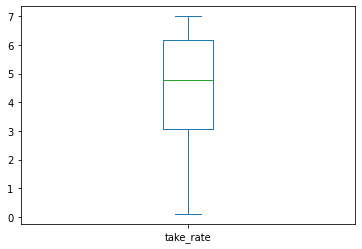

In [ ]:
a.plot.box()

Feature(date) check, remove the transactions are not in selected time range

In [ ]:
# check the order datetime
from pyspark.sql import functions as F
new_df = new_data.filter(
    (F.col('order_datetime') >= '2021-02-28') 
    & (F.col('order_datetime') <= '2022-08-28')
)

print(new_df.count(),len(new_df.columns))

12047317 13


In [ ]:
new_df.select('postcode').describe()
#new_df.limit(5)

summary,postcode
count,12047317
mean,4043.344625778503
stddev,1780.6993191675258
min,1001
max,9999


In [ ]:
# check postcode
new_df = new_df.withColumn("length_of_str",F.length('postcode'))
new_df.select('length_of_str').describe()
new_df = new_df.filter(
    (F.col('length_of_str') <= 4)
    & (F.col('length_of_str') >=3)
)
new_df = new_df.drop('length_of_str')
print(new_df.count(),len(new_df.columns))

12047317 13


In [ ]:
new_df.select('postcode').describe()

summary,postcode
count,12047317
mean,4043.344625778503
stddev,1780.6993191675258
min,1001
max,9999


In [ ]:
# check postcode
new_df = new_df.withColumn("length_of_str",F.length('postcode'))
new_df.select('length_of_str').describe()
new_df = new_df.filter(
    (F.col('length_of_str') == 4)
    #&(F.col('length_of_str') >=3 )
)
new_df = new_df.drop('length_of_str')
print(new_df.count(),len(new_df.columns))

11873781 13


In [ ]:
new_df.select('postcode').describe()

summary,postcode
count,11873781
mean,4090.160012720464
stddev,1750.7133070801758
min,1001
max,9999
